In [1]:
import os 
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import glob
glob.glob("*.csv")

['submission_format.csv',
 'pm25_satellite_metadata.csv',
 'grid_metadata.csv',
 'train_labels.csv',
 'all_data.csv']

In [3]:
import pandas as pd
df = pd.read_csv("all_data.csv").drop(columns=["Unnamed: 0"])

In [4]:
df_care = df[["datetime","location","grid_id","value"]]

In [5]:
df_f = df.groupby(["location","datetime"]).mean().reset_index()#["delhi"]

In [6]:
delhi = df_f[df_f["location"]=='Los Angeles (SoCAB)']

In [7]:
set(df_f["location"])

{'Delhi', 'Los Angeles (SoCAB)', 'Taipei'}

In [8]:
la =df_f[df_f["location"]=='Los Angeles (SoCAB)'].reset_index().drop(columns=["index"])
# la["datetime"]= pd.to_datetime(la["datetime"])
la.head()

,location,datetime,value,all_47_0,all_47_1,all_47_2,all_47_3,all_47_4,all_47_5,all_47_6,...,all_55_118,all_55_119,all_55_120,all_55_121,all_55_122,all_55_123,all_55_124,all_55_125,all_55_126,all_55_127
0,Los Angeles (SoCAB),2018-02-01T08:00:00Z,14.075000,1.473164,0.237620,-0.450347,0.345416,-0.052419,0.039611,1.318122,...,0.163535,0.088578,-0.003833,0.288825,0.103857,-0.076327,-0.030244,0.008117,-0.141097,-0.066045
1,Los Angeles (SoCAB),2018-02-03T08:00:00Z,20.416667,1.987200,0.126942,-0.464041,0.301539,-0.087068,-0.038433,1.730065,...,0.158913,0.029608,0.010519,0.274864,0.095626,-0.171993,0.001440,0.131080,-0.169575,0.134116
2,Los Angeles (SoCAB),2018-02-04T08:00:00Z,19.270304,2.212989,0.193803,-0.482930,0.194463,0.085948,-0.124012,2.097894,...,0.198427,0.112452,0.060753,0.271349,0.072343,-0.097413,-0.075271,0.010564,-0.094217,0.030709
3,Los Angeles (SoCAB),2018-02-05T08:00:00Z,11.683333,1.987809,0.219807,-0.575178,0.283012,-0.090230,-0.046319,1.837340,...,0.180373,0.122904,0.022543,0.164234,0.084222,-0.102294,-0.071847,-0.153070,-0.218122,0.015092
4,Los Angeles (SoCAB),2018-02-06T08:00:00Z,15.727273,2.358978,0.031024,-0.414918,0.091019,-0.074988,-0.110740,2.101708,...,0.163297,0.010990,-0.023368,0.306129,0.024098,-0.083651,-0.106087,-0.021889,-0.018343,-0.051663


In [9]:
la = la.reset_index().drop(columns=["index"])

In [10]:
la.head()

,location,datetime,value,all_47_0,all_47_1,all_47_2,all_47_3,all_47_4,all_47_5,all_47_6,...,all_55_118,all_55_119,all_55_120,all_55_121,all_55_122,all_55_123,all_55_124,all_55_125,all_55_126,all_55_127
0,Los Angeles (SoCAB),2018-02-01T08:00:00Z,14.075000,1.473164,0.237620,-0.450347,0.345416,-0.052419,0.039611,1.318122,...,0.163535,0.088578,-0.003833,0.288825,0.103857,-0.076327,-0.030244,0.008117,-0.141097,-0.066045
1,Los Angeles (SoCAB),2018-02-03T08:00:00Z,20.416667,1.987200,0.126942,-0.464041,0.301539,-0.087068,-0.038433,1.730065,...,0.158913,0.029608,0.010519,0.274864,0.095626,-0.171993,0.001440,0.131080,-0.169575,0.134116
2,Los Angeles (SoCAB),2018-02-04T08:00:00Z,19.270304,2.212989,0.193803,-0.482930,0.194463,0.085948,-0.124012,2.097894,...,0.198427,0.112452,0.060753,0.271349,0.072343,-0.097413,-0.075271,0.010564,-0.094217,0.030709
3,Los Angeles (SoCAB),2018-02-05T08:00:00Z,11.683333,1.987809,0.219807,-0.575178,0.283012,-0.090230,-0.046319,1.837340,...,0.180373,0.122904,0.022543,0.164234,0.084222,-0.102294,-0.071847,-0.153070,-0.218122,0.015092
4,Los Angeles (SoCAB),2018-02-06T08:00:00Z,15.727273,2.358978,0.031024,-0.414918,0.091019,-0.074988,-0.110740,2.101708,...,0.163297,0.010990,-0.023368,0.306129,0.024098,-0.083651,-0.106087,-0.021889,-0.018343,-0.051663


In [6]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
# import dataset, network to train and metric to optimize
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [7]:
max_encoder_length = 36
max_prediction_length = 60

In [12]:
# la["datetime"] = pd.to_datetime(la["datetime"])

In [ ]:
la.head()

In [ ]:
data = la

In [ ]:
data["time_idx"] = data["datetime"].dt.year * 365 + data["datetime"].dt.month *30 + data["datetime"].dt.day
data["time_idx"] -= data["time_idx"].min()

In [9]:
max_prediction_length = 100
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length


NameError: name 'data' is not defined

In [10]:
time_varying_known_reals = list(data.columns[3:])
time_varying_known_reals[0:2]

NameError: name 'data' is not defined

In [11]:
data.head()

NameError: name 'data' is not defined

In [20]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    group_ids=["location"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=["location"],
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
    ],
    target_normalizer=GroupNormalizer(
        groups=[ "location"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

In [1]:
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

NameError: name 'TimeSeriesDataSet' is not defined

In [22]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/opt/conda/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)


5.016037464141846

In [5]:
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

NameError: name 'pl' is not defined

In [25]:
# find optimal learning rate
# res = trainer.tuner.lr_find(
#     tft,
#     train_dataloader=train_dataloader,
#     val_dataloaders=val_dataloader,
#     max_lr=10.0,
#     min_lr=1e-6,
# )

# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()


In [26]:
# tft.cuda()

In [4]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
#     limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=0,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

NameError: name 'EarlyStopping' is not defined

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 4.2 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 179 K 
6  | decoder_variable_selection         | Variabl

Validation sanity check: 0it [00:00, ?it/s]

RuntimeError: index 26 is out of bounds for dimension 0 with size 25

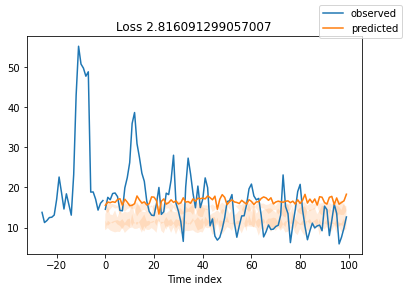

In [28]:
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [31]:
torch.zeros(1, device=device)

RuntimeError: CUDA error: device-side assert triggered

In [9]:
# la.plot()

In [29]:
from darts import TimeSeries
series = TimeSeries.from_dataframe(la, 'datetime',freq='1D',fill_missing_dates=True,fillna_value=0)
series

<TimeSeries (DataArray) (datetime: 1065, component: 257, sample: 1)>
array([[[ 1.40750000e+01],
        [ 1.47316406e+00],
        [ 2.37619722e-01],
        ...,
        [ 8.11749037e-03],
        [-1.41097450e-01],
        [-6.60453650e-02]],

       [[ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        ...,
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00]],

       [[ 2.04166667e+01],
        [ 1.98720002e+00],
        [ 1.26941753e-01],
        ...,
...
        ...,
        [ 2.28037130e-02],
        [-1.50888190e-01],
        [ 1.46438320e-01]],

       [[ 9.90347132e+00],
        [ 2.05950300e+00],
        [ 1.34824990e-01],
        ...,
        [-4.46535500e-02],
        [-7.38721500e-02],
        [ 1.68212320e-02]],

       [[ 1.26434488e+01],
        [ 2.82920892e+00],
        [-2.15811103e-02],
        ...,
        [ 1.01307613e-01],
        [-1.63362884e-01],
        [ 1.32557200e-01]]])
Coordinates:
  * datetime   (datetime) object 1517472000000000000 ... 1609401600000000000
  * component  (component) object 'value' 'all_47_0' ... 'all_55_127'
Dimensions without coordinates: sample

In [30]:
train, val = series[:-300], series[-300:]

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset

In [32]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
# Change name
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = scaler.transform(series)

In [34]:
# val.pd_series().plot()

In [15]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [my_stopper],"accelerator": "gpu", "gpus":0 }


In [16]:
my_model = TransformerModel(
    input_chunk_length=12,
    output_chunk_length=1,
    batch_size=32,
    n_epochs=200,
    model_name="air_transformer",
    nr_epochs_val_period=10,
    d_model=16,
    nhead=8,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    force_reset=True,
    torch_device_str= "cuda" 
)

[2022-03-20 19:21:51,257] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: `torch_device_str` is deprecated and will be removed in a coming Darts version. For full support of all torch devices, use PyTorch-Lightnings trainer flags and pass them inside `pl_trainer_kwargs`. Flags of interest are {`accelerator`, `gpus`, `auto_select_gpus`, `devices`}. For more information, visit https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-flags
[2022-03-20 19:21:51,257] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: `torch_device_str` is deprecated and will be removed in a coming Darts version. For full support of all torch devices, use PyTorch-Lightnings trainer flags and pass them inside `pl_trainer_kwargs`. Flags of interest are {`accelerator`, `gpus`, `auto_select_gpus`, `devices`}. For more information, visit https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-flags


In [17]:
pl_trainer_kwargs

{'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping at 0x7f4bd7efcdf0>],
 'accelerator': 'gpu',
 'gpus': 0}

In [18]:
my_model.fit(series=train_scaled, val_series=val_scaled, verbose=True)

[2022-03-20 19:21:55,704] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 753 samples.
[2022-03-20 19:21:55,704] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 753 samples.
[2022-03-20 19:21:55,731] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:21:55,731] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-20 19:21:55,741] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:21:55,741] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [20]:
dir(scaler)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_fit_called',
 '_fit_iterator',
 '_fitted_params',
 '_inverse_transform_iterator',
 '_n_jobs',
 '_name',
 '_reshape_in',
 '_reshape_out',
 '_transform_iterator',
 '_verbose',
 'fit',
 'fit_transform',
 'fitted_params',
 'inverse_transform',
 'name',
 'set_n_jobs',
 'set_verbose',
 'transform',
 'transformer',
 'transformer_instances',
 'ts_fit',
 'ts_inverse_transform',
 'ts_transform']

<AxesSubplot:xlabel='datetime'>

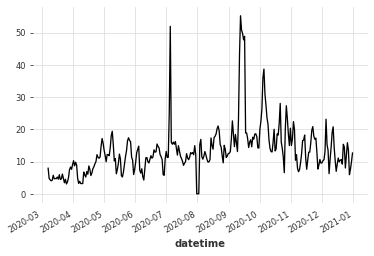

In [28]:
scaler.inverse_transform(val_scaled).pd_series().plot()

In [ ]:
scaler.inverse_transform(my_model.predict(100)).pd_series().plot()

In [27]:
best_model.predict(100)


NameError: name 'best_model' is not defined

In [40]:
from darts.datasets import EnergyDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score
from darts.datasets import EnergyDataset


Text(0.5, 1.0, 'Hourly generation hydro run-of-river and poundage')

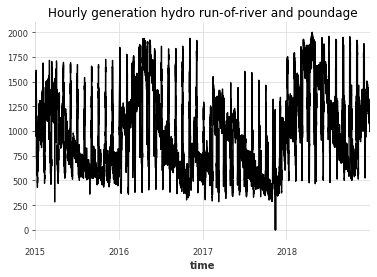

In [41]:
df = EnergyDataset().load().pd_dataframe()
df["generation hydro run-of-river and poundage"].plot()
plt.title("Hourly generation hydro run-of-river and poundage")

Text(0.5, 1.0, 'Daily generation hydro run-of-river and poundage')

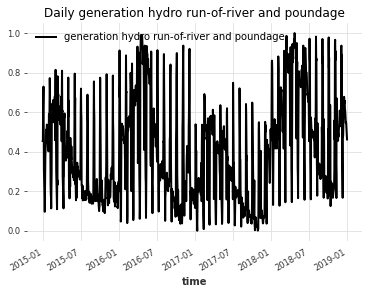

In [42]:
df_day_avg = df.groupby(df.index.astype(str).str.split(" ").str[0]).mean().reset_index()
filler = MissingValuesFiller()
scaler = Scaler()
series = scaler.fit_transform(
    filler.transform(
        TimeSeries.from_dataframe(
            df_day_avg, "time", ["generation hydro run-of-river and poundage"]
        )
    )
).astype(np.float32)
series.plot()
plt.title("Daily generation hydro run-of-river and poundage")

In [43]:
train, val = series.split_after(pd.Timestamp("20170901"))

In [46]:
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats_run",
    torch_device_str= "cuda" 
)

[2022-03-20 19:33:59,152] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: `torch_device_str` is deprecated and will be removed in a coming Darts version. For full support of all torch devices, use PyTorch-Lightnings trainer flags and pass them inside `pl_trainer_kwargs`. Flags of interest are {`accelerator`, `gpus`, `auto_select_gpus`, `devices`}. For more information, visit https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-flags
[2022-03-20 19:33:59,152] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: `torch_device_str` is deprecated and will be removed in a coming Darts version. For full support of all torch devices, use PyTorch-Lightnings trainer flags and pass them inside `pl_trainer_kwargs`. Flags of interest are {`accelerator`, `gpus`, `auto_select_gpus`, `devices`}. For more information, visit https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-flags


In [47]:
model_nbeats.fit(train, val_series=val, verbose=True)

[2022-03-20 19:34:00,196] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 940 samples.
[2022-03-20 19:34:00,196] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 940 samples.
[2022-03-20 19:34:00,265] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
[2022-03-20 19:34:00,265] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
[2022-03-20 19:34:00,266] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-20 19:34:00,266] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [129]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val))

In [83]:
# prediction

<TimeSeries (DataArray) (datetime: 300, component: 1, sample: 1)>
array([[[13.21174447]],

       [[12.94562075]],

       [[12.41802593]],

       [[12.87148589]],

       [[13.28947566]],

       [[13.28391035]],

       [[12.92012312]],

       [[13.21376536]],

       [[12.94764164]],

       [[12.42004682]],

...

       [[12.9543426 ]],

       [[13.37233236]],

       [[13.36676705]],

       [[13.00297982]],

       [[13.29662207]],

       [[13.03049835]],

       [[12.50290353]],

       [[12.95636349]],

       [[13.37435326]],

       [[13.36878795]]])
Coordinates:
  * datetime   (datetime) object 1583568000000000000 ... 1609401600000000000
  * component  (component) object 'value'
Dimensions without coordinates: sample

TypeError: Plotting requires coordinates to be numeric, boolean, or dates of type numpy.datetime64, datetime.datetime, cftime.datetime or pandas.Interval. Received data of type object instead.

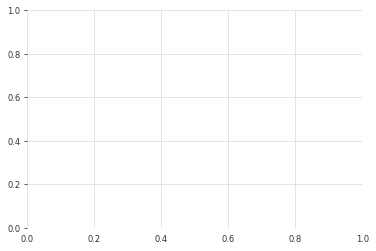

In [62]:
import matplotlib.pyplot as plt

series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()